In [ ]:
!pip install scanpy
!pip install igraph
!pip install leidenalg
!pip install memory-profiler

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import gzip
import os 

from scipy.stats import median_abs_deviation ## use in function is_outlier
from scipy.io import mmread                  ## use in function get_matrix


def get_matrix(matrix_file):
    with gzip.open(matrix_file, 'rb') as f:
        sparse_matrix = mmread(f)
    dense_matrix = sparse_matrix.todense()  # Dimensions: cells x genes
    return dense_matrix


barcodes_all = pd.DataFrame()
features_all = pd.DataFrame()
matrix_all = None  


meta_path = './input_data/GSE227828_raw_clinical_metadata.csv'

meta_df = pd.read_csv(meta_path)
samples = meta_df[['SAMPLE_ID','series_id']]


	
for series in samples['series_id'].unique():
    path = f'./input_data/{series}_RAW_extracted'
    files = os.listdir(path)

    features_path = [file for file in files if file.endswith('features.tsv.gz')][0]
    features = pd.read_csv(os.path.join(path, features_path), compression='gzip', header=None, sep='\t')
    features = features.rename(columns = {0: 'gene_ids', 1: 'code', 2: 'feature_types'})
    for sample in samples['SAMPLE_ID']:
        list_samples = [file for file in files if file.startswith(sample)]

        barcodes_path = [file for file in list_samples if file.endswith('barcodes.tsv.gz')][0]
        barcodes = pd.read_csv(os.path.join(path, barcodes_path), compression='gzip', header=None, sep='\t')[:1000] #############################
        barcodes['sample_id'] = sample
        barcodes['dataset']   = series

        matrix_path = [file for file in list_samples if file.endswith('matrix.mtx.gz')][0] 
        matrix = np.array(get_matrix(os.path.join(path, matrix_path))[:,:1000].T) ################################# 

        barcodes_all = pd.concat([barcodes_all, barcodes], ignore_index=True)
        if matrix_all is None:
            matrix_all = matrix
        else:
            matrix_all = np.vstack([matrix_all, matrix])


In [17]:


############################ Pre-processing ####################################
# Part 0
################################################################################
# organizing the obs dataset to follow with the basic analysis

def organizing_and_QC(matrix_all, barcodes_all, features):
  adata = ad.AnnData(X= matrix_all, var=features ,obs=barcodes_all.iloc[:,[0]])

  adata.obs = adata.obs.rename(columns = {0: 'barcodes'})
  adata.obs['sample_id'] = barcodes_all['sample_id'].astype(str).tolist()
  adata.obs['cell_id']   = adata.obs.sample_id + '_'+ adata.obs.barcodes
  adata.obs = adata.obs.set_index('cell_id')
  adata.obs['dataset'] = barcodes_all['dataset'].astype(str).tolist()
  adata.obs = adata.obs.drop(columns=  'barcodes')

  #. Organizing the var dataset also
  #adata.var = adata.var.rename(columns = {1: '',2: 'feature_types'})
  adata.var = adata.var.set_index('code')
  adata.var_names_make_unique()

  # Separating in different genes:
  # mitochondrial genes
  adata.var["mt"] = adata.var_names.str.startswith("MT-")
  # ribosomal genes
  adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
  # hemoglobin genes.
  adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

  #### Calculating quality control metrics
  sc.pp.calculate_qc_metrics(
      adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20,30,50],
      log1p=True
  )
  return adata

# Helper function to verify outlier points
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        M > np.median(M) + nmads * median_abs_deviation(M)
    )
    return outlier


############################ Processing #######################################
# Part 1 #######################################################################
# Filters to cells and genes in low quality
def filters_cell_genes(adata, min_cells = 100, min_genes = 200):
  adata.obs["outlier"] = (
      is_outlier(adata, "log1p_total_counts", 5)
      | is_outlier(adata, "log1p_n_genes_by_counts", 5)
      | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
  )

  adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
      adata.obs["pct_counts_mt"] > 8
  )

  sc.pp.filter_cells(adata, min_genes= min_genes)
  sc.pp.filter_genes(adata, min_cells= min_cells)

  return adata


# Part 2 #######################################################################
# Initial normalization
def normalization(adata, target_sum = 1e4):
  adata.layers["raw_counts"] = adata.X.copy()
  sc.pp.normalize_total(adata, target_sum= target_sum)
  adata.layers['norm_counts'] = adata.X.copy()

  return adata

# Selection of highly variable genes
def highly_genes_and_log(adata, n_top_genes = 2000, subset = False):
  sc.pp.highly_variable_genes(
      adata, flavor="cell_ranger", n_top_genes= n_top_genes, subset= subset
  )  ### It could be setted subset= True to really filter this dataset

  # Logaritmization
  sc.pp.log1p(adata)
  adata.layers["log1p_norm"] = adata.X.copy()

  return adata

# Part 3 #######################################################################
# dimentional reduction
def dimentional_reduction(adata, n_comps = 50):
  sc.tl.pca(adata, n_comps= n_comps)

  return adata

# Part 4 #######################################################################
# Clustering and Visualization

def clustering_and_visualization(adata, n_neighbors = 15, n_pcs = 30,
                                 early_exaggeration = 12, learning_rate = 1000,
                                 metric = 'euclidean', n_jobs = 1, perplexity = 30,
                                 use_rep = 'X_pca', resolution = 1.0,
                                 key_added = 'leiden_res_1'):

  sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
  sc.tl.tsne(adata, n_pcs=50, early_exaggeration = 12, learning_rate = 1000,
            metric = 'euclidean', n_jobs = 1, perplexity = 30, use_rep = 'X_pca')
  sc.tl.umap(adata)                                               ### put the save = '.png' to visualize a figure
  sc.tl.leiden(adata, resolution=1.0, key_added = 'leiden_res_1')
  return adata


In [18]:
adata = organizing_and_QC(matrix_all, barcodes_all, features)
adata = filters_cell_genes(adata)
adata = normalization(adata)
adata = highly_genes_and_log(adata)
adata = dimentional_reduction(adata)
adata = clustering_and_visualization(adata)

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
from time import time
from memory_profiler import memory_usage

# List to store the benchmarking results
benchmark_results = []

def benchmark_function(func, *args, **kwargs):
    """Benchmark a function, measuring time and memory usage."""
    start_time = time()
    mem_before = memory_usage(max_usage=True, retval=False)

    result = func(*args, **kwargs)

    mem_after = memory_usage(max_usage=True, retval=False)
    elapsed_time = time() - start_time
    memory_used = mem_after - mem_before

    print(f"Function {func.__name__} took {elapsed_time:.2f} seconds")
    print(f"Memory used: {memory_used:.2f} MB\n")

    # Append the results to the list
    benchmark_results.append({
        "function": func.__name__,
        "elapsed_time": elapsed_time,
        "memory_used": memory_used
    })

    return result

# Using the benchmark_function for each step
adata = benchmark_function(organizing_and_QC, matrix_all, barcodes_all, features)
adata = benchmark_function(filters_cell_genes, adata)
adata = benchmark_function(normalization, adata)
adata = benchmark_function(highly_genes_and_log, adata)
adata = benchmark_function(dimentional_reduction, adata)
adata = benchmark_function(clustering_and_visualization, adata)


/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Function organizing_and_QC took 18.14 seconds
Memory used: 10.68 MB



/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Function filters_cell_genes took 22.02 seconds
Memory used: 560.44 MB

Function normalization took 1.47 seconds
Memory used: 756.90 MB

Function highly_genes_and_log took 1.97 seconds
Memory used: 382.74 MB

Function dimentional_reduction took 6.07 seconds
Memory used: 101.27 MB

Function clustering_and_visualization took 241.02 seconds
Memory used: 659.52 MB



In [5]:
results_5000_1 =  [{'function': 'organizing_and_QC',
  'elapsed_time': 24.438429832458496,
  'memory_used': 8.3515625},
 {'function': 'filters_cell_genes',
  'elapsed_time': 24.52515935897827,
  'memory_used': 557.890625},
 {'function': 'normalization',
  'elapsed_time': 1.8797855377197266,
  'memory_used': 756.8984375},
 {'function': 'highly_genes_and_log',
  'elapsed_time': 2.117156982421875,
  'memory_used': 382.3515625},
 {'function': 'dimentional_reduction',
  'elapsed_time': 5.060164213180542,
  'memory_used': 101.8046875},
 {'function': 'clustering_and_visualization',
  'elapsed_time': 235.94508004188538,
  'memory_used': 664.0546875}]

results_5000_2 = [{'function': 'organizing_and_QC',
  'elapsed_time': 14.86401891708374,
  'memory_used': 11.109375},
 {'function': 'filters_cell_genes',
  'elapsed_time': 21.765908002853394,
  'memory_used': 564.89453125},
 {'function': 'normalization',
  'elapsed_time': 1.179389238357544,
  'memory_used': 756.8984375},
 {'function': 'highly_genes_and_log',
  'elapsed_time': 2.3997156620025635,
  'memory_used': 382.765625},
 {'function': 'dimentional_reduction',
  'elapsed_time': 6.627591371536255,
  'memory_used': 101.8203125},
 {'function': 'clustering_and_visualization',
  'elapsed_time': 248.12342762947083,
  'memory_used': 660.81640625}]

results_5000_3 =  [{'function': 'organizing_and_QC',
  'elapsed_time': 18.141294479370117,
  'memory_used': 10.67578125},
 {'function': 'filters_cell_genes',
  'elapsed_time': 22.017560482025146,
  'memory_used': 560.44140625},
 {'function': 'normalization',
  'elapsed_time': 1.4689760208129883,
  'memory_used': 756.8984375},
 {'function': 'highly_genes_and_log',
  'elapsed_time': 1.9701988697052002,
  'memory_used': 382.73828125},
 {'function': 'dimentional_reduction',
  'elapsed_time': 6.068096876144409,
  'memory_used': 101.2734375},
 {'function': 'clustering_and_visualization',
  'elapsed_time': 241.01917695999146,
  'memory_used': 659.515625}]



In [7]:
adata

AnnData object with n_obs × n_vars = 9741 × 10187
    obs: 'sample_id', 'dataset', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_30_genes', 'pct_counts_in_top_50_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'leiden_res_1'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'tsne', 'umap', 'leiden_res_1'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'norm_counts', 'log1p_norm'
    obsp: 'distances', 'connectivities'

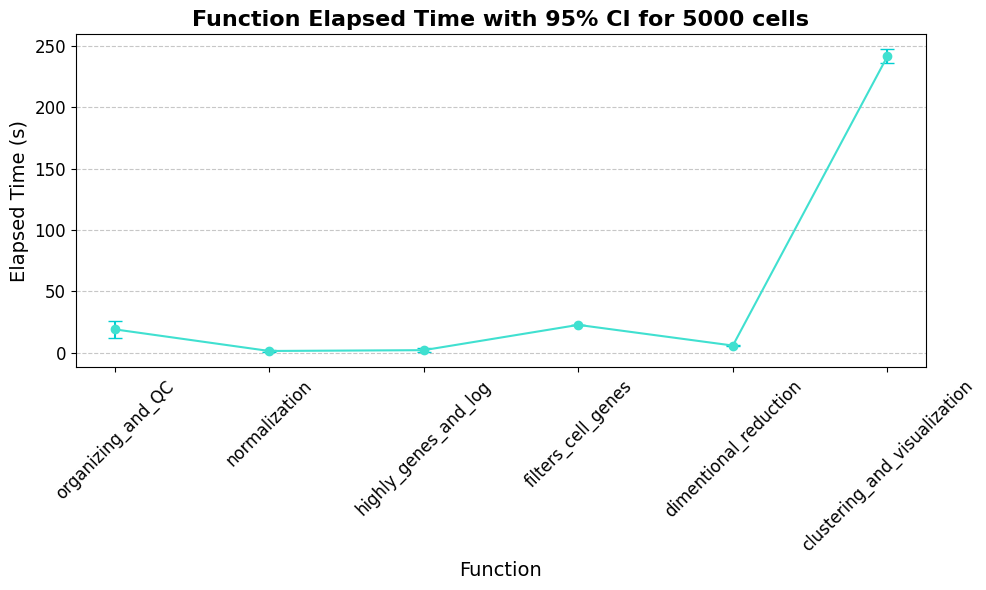

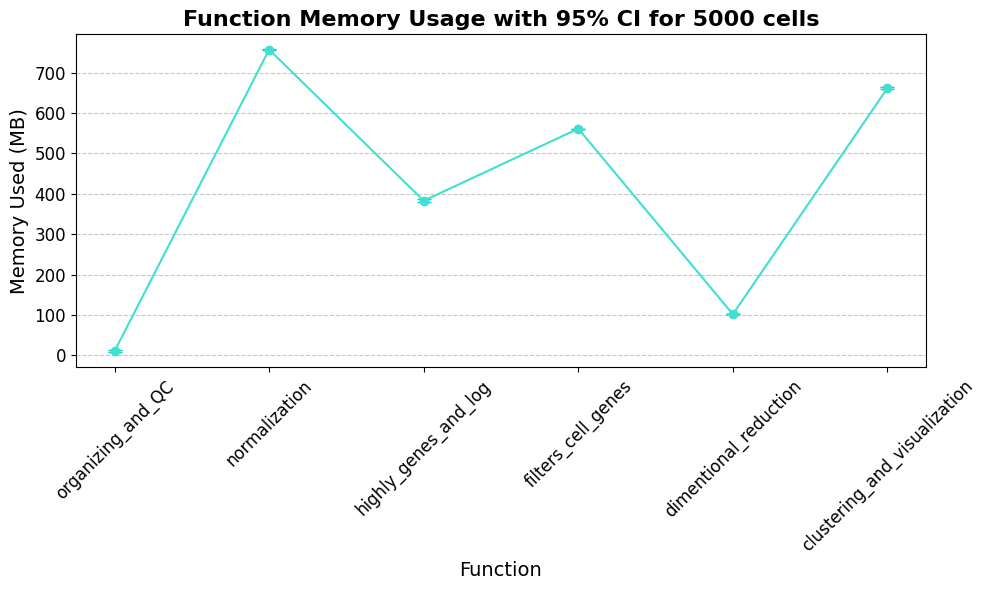

In [6]:
from scipy.stats import sem
import matplotlib.pyplot as plt

results_list = [results_5000_1, results_5000_2, results_5000_3]

# Flatten results
all_results = []
for run in results_list:
    all_results.extend(run)

df = pd.DataFrame(all_results)

# Calculate mean and confidence intervals
summary = df.groupby('function').agg(
    mean_time=('elapsed_time', 'mean'),
    ci_time=('elapsed_time', sem),
    mean_memory=('memory_used', 'mean'),
    ci_memory=('memory_used', sem)
).reset_index()

# Improved visualization with a focus on aesthetics and turquoise color
plt.figure(figsize=(10, 6))
plt.errorbar(
    summary['function'][::-1], summary['mean_time'][::-1], yerr=summary['ci_time'] * 1.96,
    fmt='o-', capsize=5, color='turquoise', ecolor='darkturquoise', label="Elapsed Time"
)
plt.title("Function Elapsed Time with 95% CI for 5000 cells", fontsize=16, fontweight='bold')
plt.ylabel("Elapsed Time (s)", fontsize=14)
plt.xlabel("Function", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.errorbar(
    summary['function'][::-1], summary['mean_memory'][::-1], yerr=summary['ci_memory'] * 1.96,
    fmt='o-', capsize=5, color='turquoise', ecolor='darkturquoise', label="Memory Used"
)
plt.title("Function Memory Usage with 95% CI for 5000 cells", fontsize=16, fontweight='bold')
plt.ylabel("Memory Used (MB)", fontsize=14)
plt.xlabel("Function", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

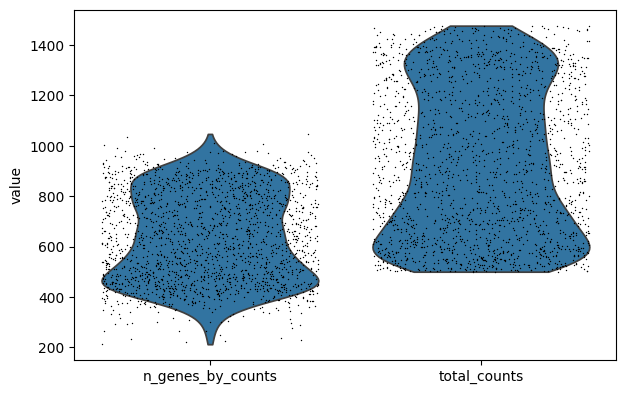

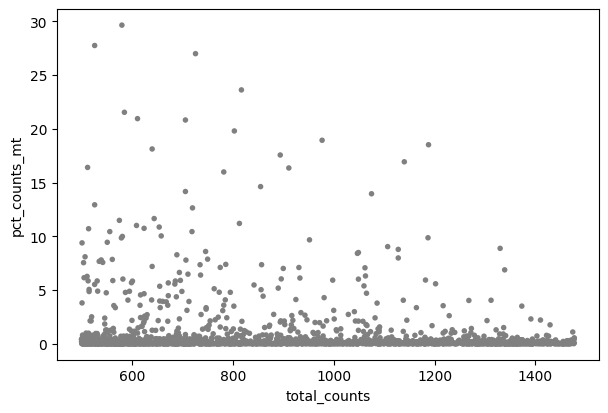

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

Silhouette score: 0.09926342219114304


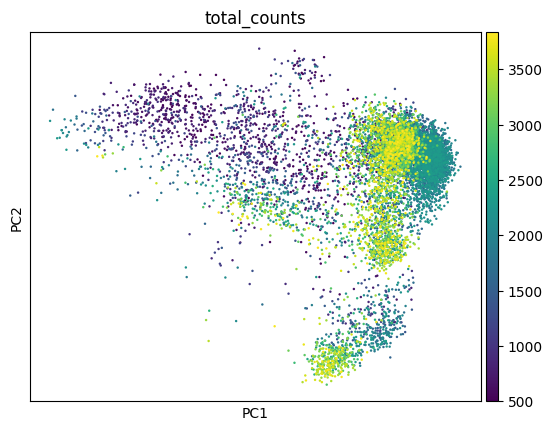

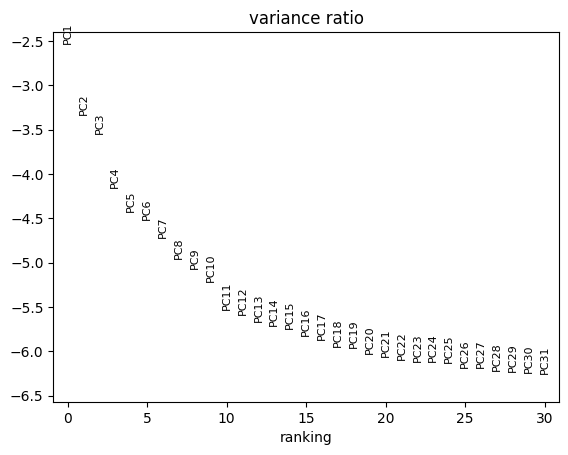

In [7]:
from sklearn.metrics import silhouette_score

# Compute silhouette score for clusters
labels = adata.obs['leiden_res_1']
silhouette = silhouette_score(adata.obsm['X_pca'], labels)
print(f"Silhouette score: {silhouette}")

sc.pl.pca(adata, color='total_counts')
sc.pl.pca_variance_ratio(adata, log=True)

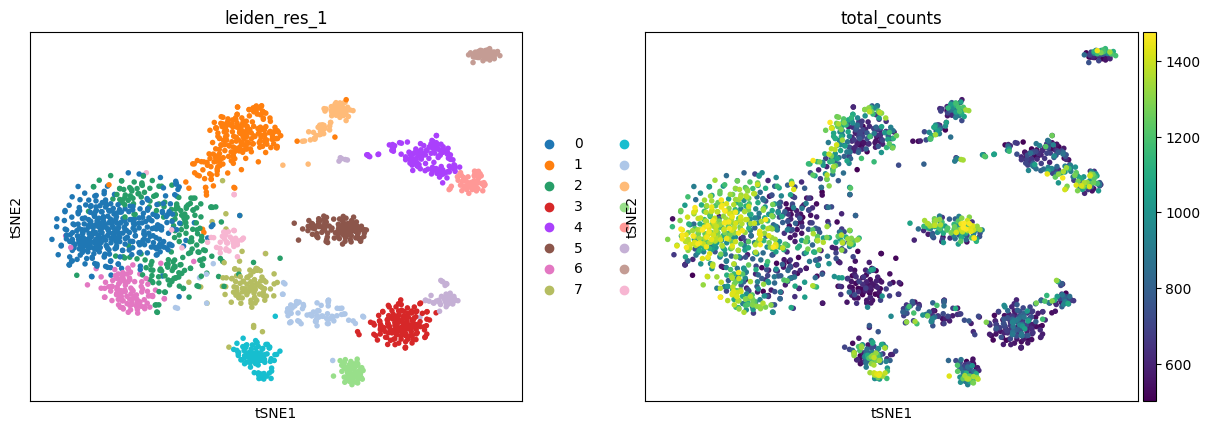

In [23]:
sc.pl.tsne(adata, color=['leiden_res_1', 'total_counts'])

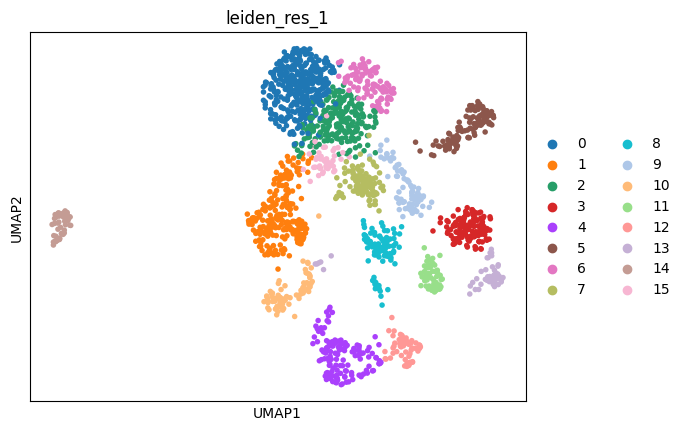

In [25]:
fig = sc.pl.umap(adata, color='leiden_res_1', show=False)
plt.savefig('umap_clusters.png')

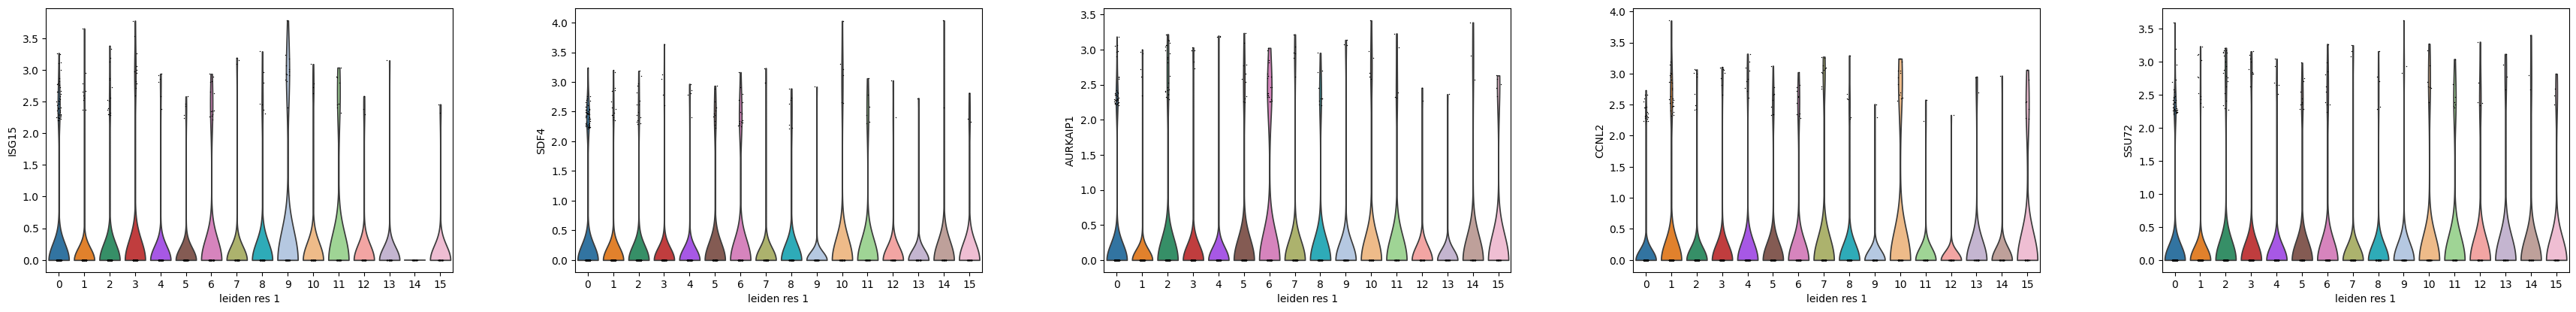

In [27]:
sc.pl.violin(adata, adata.var_names[:5], groupby='leiden_res_1')

In [25]:
adata.var_names[:100]

Index(['HES4', 'TNFRSF4', 'SSU72', 'PARK7', 'RBP7', 'SRM', 'MAD2L2', 'AGTRAP',
       'TNFRSF1B', 'EFHD2', 'NECAP2', 'HP1BP3', 'C1QA', 'C1QB', 'HNRNPR',
       'GALE', 'STMN1', 'CD52', 'FGR', 'ATPIF1', 'SESN2', 'EIF3I', 'LCK',
       'MARCKSL1', 'SFPQ', 'PSMB2', 'MEAF6', 'NDUFS5', 'CAP1', 'SMAP2',
       'C1orf228', 'PRDX1', 'TMEM69', 'SCP2', 'MAGOH', 'JAK1', 'CCBL2', 'GBP2',
       'CD53', 'DENND2D', 'C1orf162', 'RHOC', 'CD2', 'RP11-782C8.1', 'TXNIP',
       'CD160', 'RP11-277L2.3', 'APH1A', 'MRPS21', 'CTSS', 'MRPL9', 'S100A10',
       'S100A9', 'S100A8', 'S100A6', 'S100A4', 'RAB13', 'TPM3', 'HAX1', 'PMVK',
       'PBXIP1', 'DAP3', 'CCT3', 'SH2D2A', 'MNDA', 'FCER1A', 'TAGLN2', 'LY9',
       'FCER1G', 'SDHC', 'FCGR3A', 'FCRLA', 'CD247', 'CREG1', 'RCSD1', 'XCL2',
       'XCL1', 'PRDX6', 'C1orf21', 'TPR', 'PTPRC', 'PTPN7', 'NUCKS1', 'G0S2',
       'TRAF3IP3', 'NENF', 'CAPN2', 'COA6', 'ARID4B', 'RP11-156E8.1', 'SH3YL1',
       'ID2', 'HPCAL1', 'RAB10', 'OST4', 'PPM1G', 'LBH', 'SRSF7', 'ZF

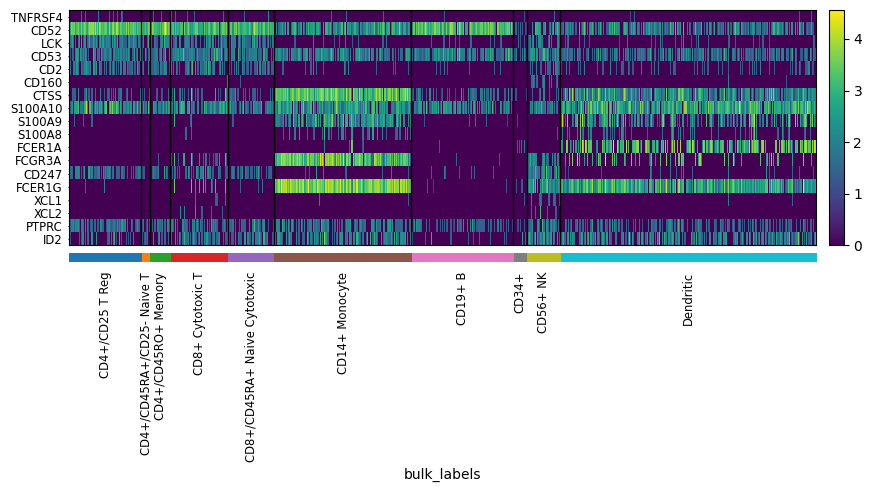

In [11]:
import scanpy as sc
adata = sc.datasets.pbmc68k_reduced()
markers = adata.var_names[:10]
markers = ['TNFRSF4', 'CD52', 'LCK', 'CD53', 'CD2', 'CD160', 'CTSS', 'S100A10',
 'S100A9', 'S100A8', 'FCER1A', 'FCGR3A', 'CD247', 'FCER1G', 'XCL1', 'XCL2',
 'PTPRC', 'ID2']
sc.pl.heatmap(adata, markers, groupby='bulk_labels', swap_axes=True)